In [ ]:
# To use it in colab use this code to import the data. 
# Its necessarc to complet the following steps in advance: 
# 1. Create a folder in your drive with the Name DMC. 
# 2. Go to the shard folder 02 Data and do a right click -> Add shortcut to Drive / Drve Verbindung hinzufügen -> dann auf den eben erstellen order DMC navigieren
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8MB 2.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617672 sha256=2acfa9def73afaad22c6378c5c04262c1f7f99a7ad1a0800871833b71b7809a4
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

#Preprocessing, EDA

In [ ]:
##Load Movie Title data
df_merged = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/final_movies_metadata_linked.csv", delimiter=';')
df_merged.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df_merged.head()

,netflix_id,title,release_year,metadata_id,imdb_id,original_language,overview,tagline,metadata_genres,netflix_genres
0,402,Pan Tadeusz,1999,4966,tt0170351,pl,A grand and patriotic tale of Poland's struggl...,NaN,"[{'id': 10752, 'name': 'War'}, {'id': 18, 'nam...",Drama|History|Romance|War
1,17617,Ginger,1971,89072,tt0067133,en,The police suspect that a drug and forced-pros...,"Every man wanted her, no man could tame her! T...","[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",Action|Crime|Drama
2,11805,The Big Bounce,2004,12634,tt0315824,en,A small-time con artist and a Hawaiian real es...,It's all in who you trust,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",Comedy|Crime
3,459,Basquiat,1996,549,tt0115632,en,Director Julian Schnabel illustrates the portr...,"In 1981, A Nineteen-Year-Old Unknown Graffiti ...","[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",Biography|Drama
4,4607,Melody Time,1948,13757,tt0040580,en,Melody Time is an animated feature produced by...,NaN,"[{'id': 10402, 'name': 'Music'}, {'id': 10751,...",Animation|Comedy|Family|Musical


In [ ]:
df_ratings = pd.read_csv("/content/drive/My Drive/Web Mining Project/NEW_DATA/final_netflix_ratings.csv", delimiter=';')

In [ ]:
df_ratings.head()

,Unnamed: 0,movie_id,user_id,rating
0,692,3,1025579,4
1,693,3,712664,5
2,694,3,1331154,4
3,695,3,2632461,3
4,696,3,44937,5


In [ ]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85179634 entries, 0 to 85179633
Data columns (total 4 columns):
 #   Column      Dtype
---  ------      -----
 0   Unnamed: 0  int64
 1   movie_id    int64
 2   user_id     int64
 3   rating      int64
dtypes: int64(4)
memory usage: 2.5 GB


In [ ]:
#Create dictionary of movie_id to title so that we can use it later to determine title when recommending items
dict_id_title = df_merged.set_index("netflix_id")["title"].to_dict()
print(dict_id_title)

{402: 'Pan Tadeusz', 17617: 'Ginger', 11805: 'The Big Bounce', 459: 'Basquiat', 4607: 'Melody Time', 8914: 'Comes a Horseman', 6163: "Betsy's Wedding", 16982: 'The Black Stallion Returns', 3889: 'Assisted Living', 9950: 'Flashdance', 405: 'Wings of Desire', 11616: "A Summer's Tale", 16787: 'Primary', 2139: 'The Color of Money', 8568: 'Ordinary Decent Criminal', 16500: 'White Heat', 14276: 'Our Lips Are Sealed', 4369: "Porky's", 16438: 'The Wedding Singer', 5793: 'Underworld', 985: 'The Mummy', 14254: 'A Bridge Too Far', 6259: 'Night of the Demons', 6910: 'Down to You', 7822: 'Millionaires Express', 10969: 'Jail Bait', 17229: 'Japanese Story', 15929: 'Shining Through', 8176: 'The Locusts', 2140: 'For the Boys', 8586: 'Jeremiah Johnson', 10315: 'The Millionairess', 4472: 'Love Actually', 16824: 'Our Town', 5207: 'Project Moon Base', 3290: 'The Godfather: Part II', 4001: 'The Four Feathers', 6923: 'Color of Night', 4331: 'Owning Mahowny', 3542: 'Beautiful Thing', 11182: 'Master and Comman

In [ ]:
##Create Movies dataframe to explore movie's avg rating and number of ratings received by user
df_titles = pd.DataFrame(df_ratings.groupby('movie_id')['rating'].mean())
df_titles['count'] = df_ratings.groupby('movie_id')['rating'].count()
df_titles["title"] = pd.Series(dict_id_title)

In [ ]:
df_titles.head()

,rating,count,title
movie_id,,,
3,3.641153,2012,Character
5,3.919298,1140,WWE: The Rise & Fall of ECW
8,3.189805,14910,What the #$*! Do We (K)now!?
12,3.417582,546,My Favorite Brunette
17,2.903208,7108,7 Seconds


In [ ]:
##Create Users dataframe to explore user's avg rating and number of ratings given by user
df_users = pd.DataFrame(df_ratings.groupby('user_id')['rating'].mean())
df_users['count'] = df_ratings.groupby('user_id')['rating'].count()
df_users.head()

,rating,count
user_id,,
6,3.445714,525
7,3.970626,783
8,4.212766,94
10,3.427350,234
25,3.000000,19


In [ ]:
print(df_users.shape)
print(df_titles.shape)

(479420, 2)
(8063, 3)


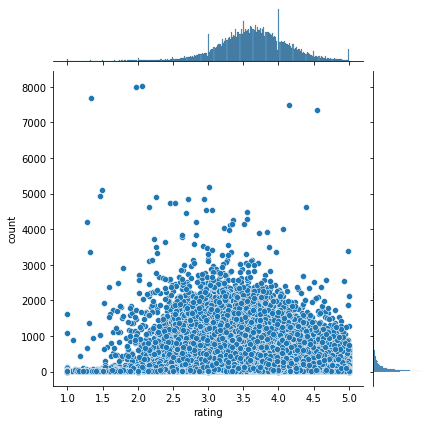

In [ ]:
sns.jointplot(x='rating', y='count', data=df_users)

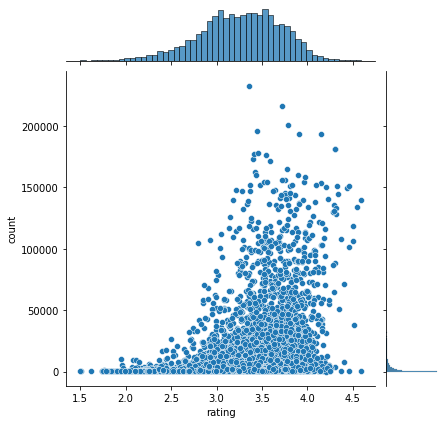

In [ ]:
sns.jointplot(x='rating', y='count', data=df_titles)

(0.0, 5.0)

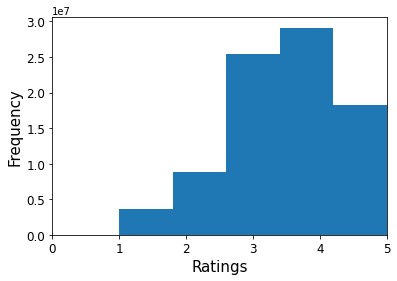

In [ ]:
df_ratings['rating'].hist(bins=5, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("Ratings", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.xlim([0,5.0])

Text(0, 0.5, 'Frequency of users')

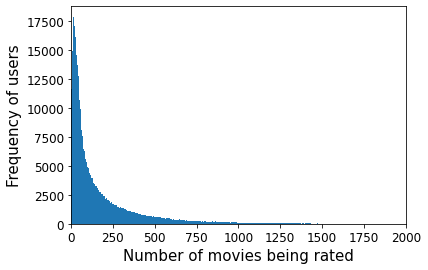

In [ ]:
# Distribution of the number of users and the number of movies rated per user
df_users['count'].hist(bins=2000, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlim([0,2000])
plt.xlabel("Number of movies being rated", fontsize=15)
plt.ylabel("Frequency of users",fontsize=15)

In [ ]:
##Removing users who rated less than 50 movies and removing movies which are not rated y atleast 300 users
df_users_f = df_users.drop(df_users[df_users['count'] < 100].index)
df_users_f = df_users_f.drop(df_users_f[df_users_f['count'] > 1750].index)
df_titles_f = df_titles.drop(df_titles[df_titles['count'] < 100].index)

In [ ]:
print(df_titles.shape)
print(df_titles_f.shape)
print(df_users.shape)
print(df_users_f.shape)

print('Preserved rate of the movies : {0:.2f} %'.format((df_titles_f.shape[0]/df_titles.shape[0]) * 100))
print('Preserved rate of the users : {0:.2f} %'.format((df_users_f.shape[0]/df_users.shape[0]) * 100))

(8063, 3)
(7891, 3)
(479420, 2)
(215850, 2)
Preserved rate of the movies : 97.87 %
Preserved rate of the users : 45.02 %


In [ ]:
list_users_f = list(df_users_f.index.values)
list_titles_f = list(df_titles_f.index.values)

print(len(list_users_f))
print(len(list_titles_f))

215850
7891


Text(0, 0.5, 'Frequency of users')

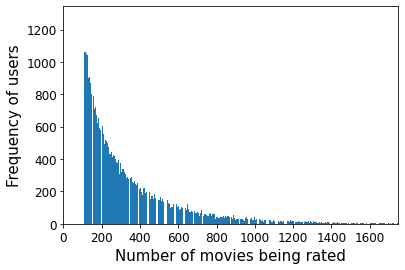

In [ ]:
# Distribution of the number of users and the number of movies rated per user
df_users_f['count'].hist(bins=2000, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlim([0,1750])
plt.xlabel("Number of movies being rated", fontsize=15)
plt.ylabel("Frequency of users",fontsize=15)

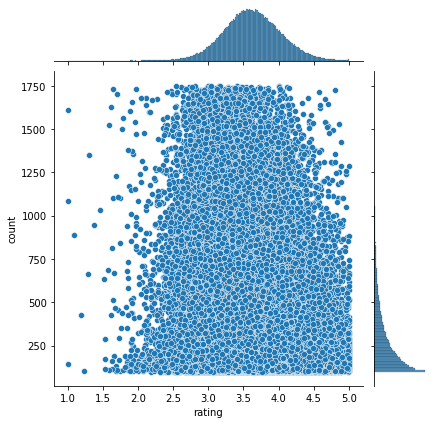

In [ ]:
sns.jointplot(x='rating', y='count', data=df_users_f)

In [ ]:
df_ratings = df_ratings[df_ratings['user_id'].isin(list_users_f)]
df_ratings = df_ratings[df_ratings['movie_id'].isin(list_titles_f)]
print(df_ratings.shape)
print(df_ratings.info(memory_usage='deep'))

(72625789, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 72625789 entries, 1 to 85179633
Data columns (total 4 columns):
 #   Column      Dtype
---  ------      -----
 0   Unnamed: 0  int64
 1   movie_id    int64
 2   user_id     int64
 3   rating      int64
dtypes: int64(4)
memory usage: 2.7 GB
None


            rating   count                                              title
movie_id                                                                     
5317      3.361267  232944                                  Miss Congeniality
15124     3.724238  216596                                   Independence Day
14313     3.783854  200832                                        The Patriot
15205     3.442166  196397                             The Day After Tomorrow
1905      4.153908  193941  Pirates of the Caribbean: The Curse of the Bla...
6287      3.905047  193295                                       Pretty Woman
11283     4.299910  181508                                       Forrest Gump
16377     4.306941  181426                                     The Green Mile
16242     3.454411  178068                                            Con Air
12470     3.411870  177556                                            Twister


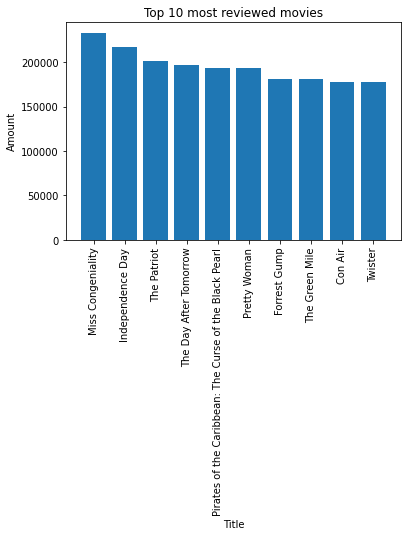

In [ ]:
most_count = df_titles.sort_values(by=['count'], ascending = False).head(10)
print(most_count)

a = list(most_count['count'])
b = list(most_count['title'])

rating_count = a
index = b

# df = pd.DataFrame({'rating_count': rating_count}, index=index)
# ax = df.plot.bar(rot=90)

plt.bar(index, rating_count)
plt.xticks(rotation = 90)
plt.xlabel('Title')
plt.ylabel('Amount')
plt.title('Top 10 most reviewed movies')
plt.show()

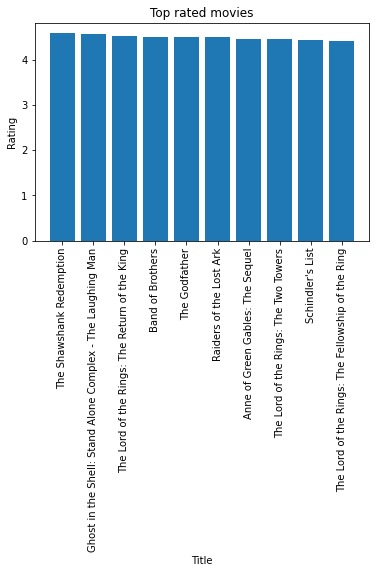

In [ ]:
most_rated = df_titles.sort_values(by=['rating'], ascending = False).head(10)
most_rated

a = list(most_rated['rating'])
b = list(most_rated['title'])

rating_count = a
index = b

# df = pd.DataFrame({'rated': rating_count}, index=index)
# ax = df.plot.bar(rot=90)

plt.bar(index, rating_count)
plt.xticks(rotation = 90)
plt.xlabel('Title')
plt.ylabel('Rating')
plt.title('Top rated movies')
plt.show()

In [ ]:
df_merged = df_merged[df_merged['netflix_id'].isin(list_titles_f)]

In [ ]:
df_ratings = reduce_mem_usage(df_ratings)
df_ratings.to_csv('/content/drive/My Drive/Web Mining Project/NEW_DATA/final_netflix_ratings_preprocessed.csv', sep=';', encoding='utf-8')

Mem. usage decreased to 1315.97 Mb (52.5% reduction)


In [ ]:
df_titles_f.to_csv('/content/drive/My Drive/Web Mining Project/NEW_DATA/final_netflix_titles.csv', sep=';', encoding='utf-8')